# Análise de informações de atendimento aos chamados de clientes Stone

### (1) Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from datetime import datetime, timedelta
from scipy import stats
import dataframe_image as dfi
import gower

### (2) Carregando a base de dados e entendendo sua estrutura

#### 2.1. Carregando as bases de dados

In [2]:
cases = pd.read_csv("cases.csv", sep=',')
creds = pd.read_csv("creds.csv", sep=',')

#### 2.2. Analisando a aparência das bases dados e sua estruturação

In [3]:
cases.head()

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU


In [4]:
creds.head()

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN
2,2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU


In [5]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                126989 non-null  int64  
 1   accountid                 77489 non-null   object 
 2   date_ref                  77489 non-null   object 
 3   channelid                 77489 non-null   float64
 4   waitingtime               77489 non-null   float64
 5   missed                    77489 non-null   object 
 6   pesquisa_de_satisfa_o__c  11585 non-null   object 
 7   assunto                   77489 non-null   object 
 8   Id                        77489 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 8.7+ MB


In [6]:
creds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Unnamed: 0              126989 non-null  int64 
 1   cred_date               126989 non-null  object
 2   shipping_address_city   126989 non-null  object
 3   shipping_address_state  126989 non-null  object
 4   max_machine             126989 non-null  object
 5   accountid               77489 non-null   object
dtypes: int64(1), object(5)
memory usage: 5.8+ MB


### (3) Tratando as bases de dados

#### 3.1 Base de dados de Chamados

> A base de dados veio com um índice importado, vamos remover a coluna referente a esse índice e, após isso, remover todas as linhas que contiverem apenas valores NaN

In [7]:
cases.drop('Unnamed: 0', 
           axis=1, 
           inplace=True) #removendo a coluna

In [8]:
cases.dropna(axis=0, 
             how='all',
             inplace=True) #removendo as linhas apenas com valores NaN

In [9]:
cases.head()

,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação,0013j00002z0CeEAAU
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros,0013j00002zQgldAAC


> Avaliando se os valores das colunas accountid e Id são iguais e, caso positivo, removendo uma das colunas desnecessárias

In [10]:
(cases['accountid'] == cases['Id']).unique() #comparando as colunas e retornando os valores exclusivos presentes no array

array([ True])

In [11]:
cases.drop('Id',
           axis=1,
           inplace=True) #removendo a coluna Id

In [12]:
cases.head()

,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros


> Renomeando as colunas para facilitar a manipulação

In [13]:
cases.rename(columns={
    'accountid': 'Id',
    'date_ref': 'Data',
    'channelid': 'Canal',
    'waitingtime': 'Espera',
    'missed': 'Atendido',
    'pesquisa_de_satisfa_o__c': 'Pesquisa_Satisfacao',
    'assunto': 'Assunto'
}, inplace=True)

In [14]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros


> Alterando os valores da coluna 'Atendido' para Sim e Não, pois com a alteração do nome, o sentido da informação também foi alterado

In [15]:
cases['Atendido'].unique() #confirmando os valores da coluna Atendido

array([False, True], dtype=object)

In [16]:
cases['Atendido'] = cases['Atendido'].map({False: 'Sim', True: 'Não'}) #Alterando os valores da coluna

In [17]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto:S920:Ativação
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Produto:Cartão pré-pago:Dúvidas
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística:Envio de Cartão:Tracking
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Pedido:Cancelamento:Outros


> Criando uma lista dos assuntos dos chamados para análise

In [18]:
assuntos = list(cases['Assunto']) #transformando a series em lista

In [19]:
Assunto_Principal = []
SubAssunto_01 = []
SubAssunto_02 = []

for i in range(len(assuntos)):
    assuntos[i].strip()
    posicao1 = assuntos[i].find(':') #encontrando a posição do 1º ':'
    posicao2 = assuntos[i][(posicao1+1):].find(':') #encontrando a posição do 2º ':' a partir do caractere seguinte ao 1º


    Assunto_Principal.append(assuntos[i][:posicao1])
    SubAssunto_01.append(assuntos[i][(posicao1+1):(posicao1 + posicao2 + 1)])
    SubAssunto_02.append(assuntos[i][(posicao1 + posicao2 + 2):])
    
#percorreu-se a lista de assuntos e separou os assuntos pelo separador ':', dividindo em três níveis

> Removendo a coluna de Assunto e incluindo na tabela as listas de assuntos explodidas e transformadas em series

In [20]:
cases.drop('Assunto', 
           axis=1, 
           inplace=True)

In [21]:
cases['Assunto_Principal'] = pd.Series(Assunto_Principal)
cases['SubAssunto_01'] = pd.Series(SubAssunto_01)
cases['SubAssunto_02'] = pd.Series(SubAssunto_02)

In [22]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados


> Verificando os valores da coluna de Pesquisa de Satisfação

In [23]:
cases['Pesquisa_Satisfacao'].unique()

array([nan, 'Enviado', 'Incrivel', 'Normal', 'Bom', 'NaoResolveu',
       'Triste', 'Cansativo', 'MalAtendido', 'Feliz', 'Pessimo'],
      dtype=object)

#### 3.2 Base de dados de Credenciamentos

> Mantendo apenas na tabela apenas as colunas para análise

In [24]:
creds.drop(['Unnamed: 0', 'shipping_address_city'], 
           axis=1, 
           inplace=True) #excluindo colunas não desejadas

creds.rename(columns={
    'accountid': 'Id',
    'cred_date': 'Data_Credenciamento',
    'shipping_address_state': 'Estado_Entrega',
    'max_machine': 'Produto_Adquirido'
}, inplace=True) #renomeando as colunas

creds.head() #exibindo a nova estrutura

,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Id
0,2020-04-18,BA,T1,NaN
1,2020-10-16,MA,T1,NaN
2,2020-09-01,TO,T1,NaN
3,2020-08-29,RJ,T3,NaN
4,2020-07-28,RJ,T3,0013j00002z0CeEAAU


In [25]:
creds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Data_Credenciamento  126989 non-null  object
 1   Estado_Entrega       126989 non-null  object
 2   Produto_Adquirido    126989 non-null  object
 3   Id                   77489 non-null   object
dtypes: object(4)
memory usage: 3.9+ MB


> A coluna de Id possui muitos valores NaN, vamos excluir todas as linhas dessa forma, pois não será útil à nossa análise

In [26]:
creds.dropna(axis=0,
             how='any',
             inplace=True) #excluindo linhas

In [27]:
creds.head()

,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Id
4,2020-07-28,RJ,T3,0013j00002z0CeEAAU
5,2020-07-28,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,RJ,T3,0013j00002z0CeEAAU
7,2020-08-28,RJ,T1,0013j00002zQgldAAC
8,2020-08-28,RJ,T1,0013j00002zQgldAAC


In [28]:
creds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77489 entries, 4 to 126988
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Data_Credenciamento  77489 non-null  object
 1   Estado_Entrega       77489 non-null  object
 2   Produto_Adquirido    77489 non-null  object
 3   Id                   77489 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


#### 3.3 Incluindo as informações da tabela de credenciamentos na tabela de chamados. .

In [29]:
cases.loc[creds['Id'] == cases['Id'], 'Data_Credenciamento'] = creds['Data_Credenciamento']
cases.loc[creds['Id'] == cases['Id'], 'Estado_Entrega'] = creds['Estado_Entrega']
cases.loc[creds['Id'] == cases['Id'], 'Produto_Adquirido'] = creds['Produto_Adquirido']
#acrescentando as informações da tabela creds na tabela cases com base no Id do cliente

In [30]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros,2020-07-28,RJ,T3
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-07-28,RJ,T3
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,2020-07-28,RJ,T3
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas,2020-08-28,RJ,T1
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados,2020-08-28,RJ,T1


In [31]:
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77489 entries, 4 to 126988
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   77489 non-null  object 
 1   Data                 77489 non-null  object 
 2   Canal                77489 non-null  float64
 3   Espera               77489 non-null  float64
 4   Atendido             77489 non-null  object 
 5   Pesquisa_Satisfacao  11585 non-null  object 
 6   Assunto_Principal    47318 non-null  object 
 7   SubAssunto_01        47318 non-null  object 
 8   SubAssunto_02        47318 non-null  object 
 9   Data_Credenciamento  77489 non-null  object 
 10  Estado_Entrega       77489 non-null  object 
 11  Produto_Adquirido    77489 non-null  object 
dtypes: float64(2), object(10)
memory usage: 7.7+ MB


> Criando uma coluna para determinar o tempo de credenciamento dos clientes, em dias

In [32]:
cases['Dias_Credenciado'] = [(datetime.strptime(list(cases['Data'])[i], '%Y-%m-%d') - 
                              datetime.strptime(list(cases['Data_Credenciamento'])[i], '%Y-%m-%d'))
                             for i in range(len(cases))]
#criando uma coluna calculada que faz a diferença em dias entre a data do chamado e a data do credenciamento do cliente

In [33]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Dias_Credenciado
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros,2020-07-28,RJ,T3,3 days
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-07-28,RJ,T3,3 days
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,2020-07-28,RJ,T3,57 days
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas,2020-08-28,RJ,T1,1 days
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados,2020-08-28,RJ,T1,1 days


### (4) Analisando as informações

#### 4.1 Análise do total de chamados abertos por período

In [34]:
analise_chamados = cases.groupby('Data').count()['Id'] #agrupando a tabela pela data
analise_chamados = analise_chamados.reset_index() #removendo a data do índice da série de dados

<AxesSubplot: title={'center': 'Análise de Chamados Abertos por Dia'}, xlabel='Dias', ylabel='Chamados Abertos'>

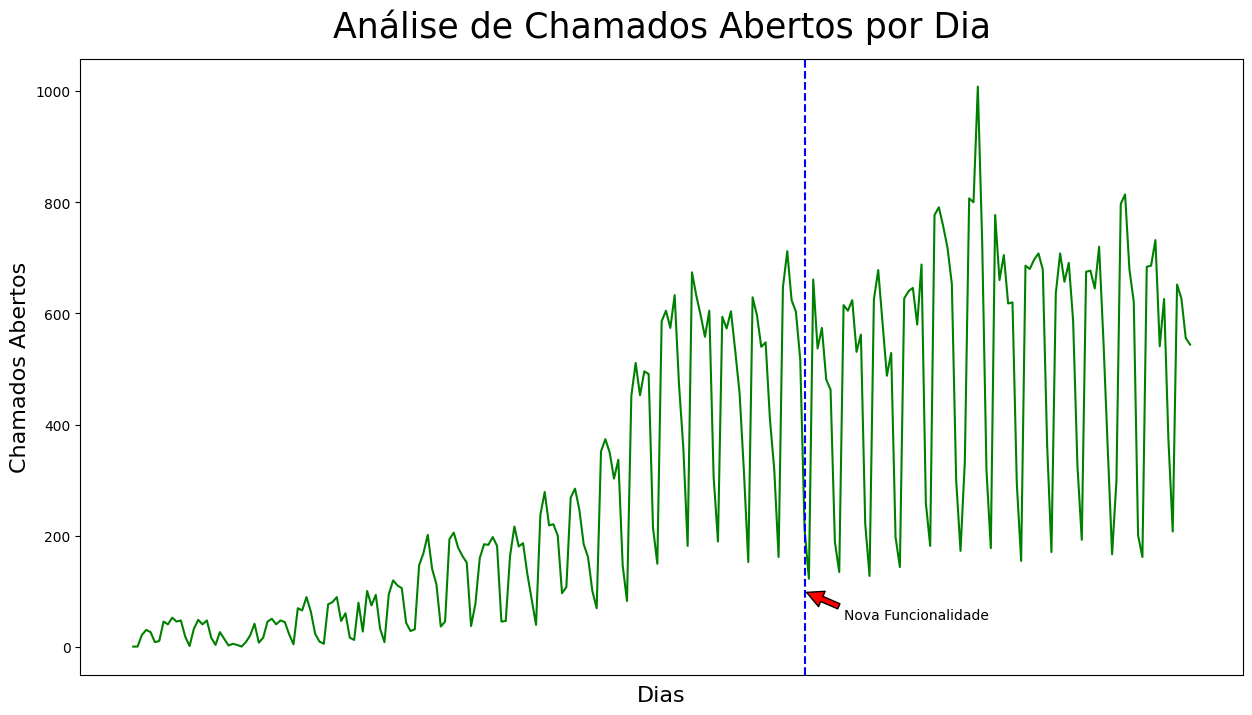

In [35]:
#criando um gráfico de linhas que permitirá analisar visualmente as diferenças entre o período pré e após implementação
plt.figure(figsize=[15, 8])

grafico_chamados = sns.lineplot(x='Data',
                                y='Id',
                                data=analise_chamados,
                                color='green')

plt.title('Análise de Chamados Abertos por Dia', 
          size=25, 
          pad=15)
plt.xlabel('Dias', size=16)
plt.xticks([])
plt.ylabel('Chamados Abertos', size=16)
plt.axvline(x='2020-08-01', 
            ymin=0, 
            ymax=max(analise_chamados['Id']),
            color='b',
            linestyle='--')

plt.annotate('Nova Funcionalidade',
             xy=('2020-08-01', 100),
             xytext=('2020-08-10', 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.savefig('grafico_ChamadosAbertosPorDia.png') #salvando o gráfico gerado em uma figura png
grafico_chamados

#### 4.2 Análise dos chamados pela média diária, antes e após a implementação da funcionalidade

In [36]:
analise_chamados['nova_implementacao'] = analise_chamados['Data'].map(lambda x: 'anterior' if x < '2020-08-01' else 'posterior')
#criando coluna para analisar se a data do chamado é anterior ou posterior a implementação da funcionalidade

In [37]:
analise_chamados.describe() #obtendo uma estatística descritiva dos dados

,Id
count,245.000000
mean,316.281633
std,261.634001
min,1.000000
25%,75.000000
50%,208.000000
75%,587.000000
max,1008.000000


In [38]:
anterior = analise_chamados.query("nova_implementacao == 'anterior'").groupby('Data').sum()
posterior = analise_chamados.query("nova_implementacao == 'posterior'").groupby('Data').sum()

C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\633244764.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  anterior = analise_chamados.query("nova_implementacao == 'anterior'").groupby('Data').sum()
C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\633244764.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  posterior = analise_chamados.query("nova_implementacao == 'posterior'").groupby('Data').sum()


In [39]:
U, p = stats.mannwhitneyu(anterior, posterior, alternative='two-sided') #aplicando o teste u nas amostras

In [40]:
if p < 0.05:
    print(f'p-value = {p}.\nAmostra de dados significativamente diferentes a um nível de significância de 5%.') #mostrando pvalor

p-value = [7.66472136e-22].
Amostra de dados significativamente diferentes a um nível de significância de 5%.


<AxesSubplot: title={'center': 'Média Diária de Chamados Abertos x Implementação da Nova Funcionalidade'}, xlabel='Implementação da Funcionalidade', ylabel='Chamados'>

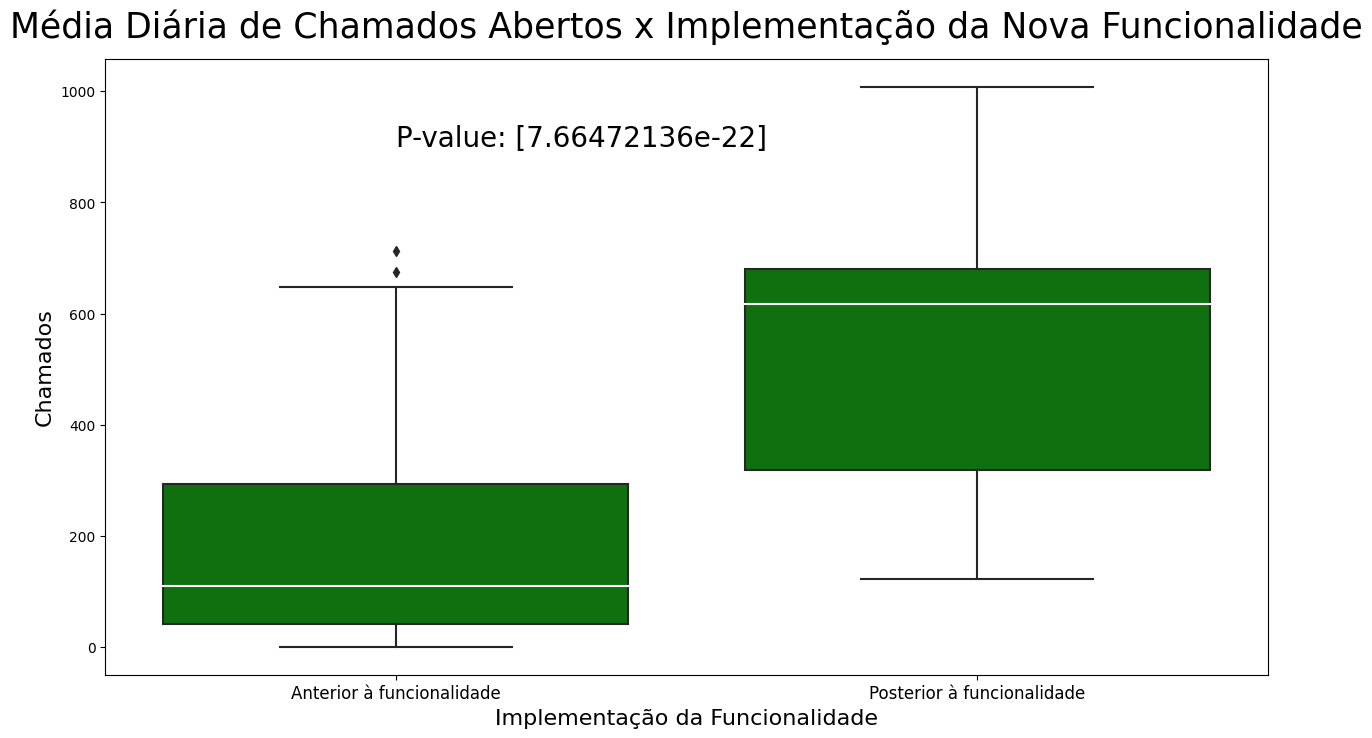

In [41]:
#criando um gráfico comparativo das médias diárias de abertura de chamados anteriores e posteriores à funcionalidade
plt.figure(figsize=[15, 8])

media_chamados = sns.boxplot(x='nova_implementacao', 
                             y='Id',                         
                             data=analise_chamados,
                             color='green',
                             medianprops={'color': 'white'})

plt.title('Média Diária de Chamados Abertos x Implementação da Nova Funcionalidade', 
          size=25,
          pad=15)
plt.ylabel('Chamados', size=16)
plt.xlabel('Implementação da Funcionalidade', size=16)

ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Anterior à funcionalidade', 'Posterior à funcionalidade'], size=12)

plt.annotate(f'P-value: {p}',
             xy=(0, 900),
             xytext=(0, 900),
             size = 20) #incluindo o p-valor no gráfico

plt.savefig('grafico_MediaDiariaChamados.png') #salvando o gráfico gerado em uma figura png
media_chamados

In [42]:
media_anterior = anterior.mean()[0]
media_posterior = posterior.mean()[0]
chamados_anterior = anterior.sum()[0]
chamados_posterior = posterior.sum()[0]

frame_medias = pd.DataFrame(data=[[chamados_anterior, media_anterior],
                                  [chamados_posterior, media_posterior], 
                                  [round(chamados_posterior/chamados_anterior,2), round(media_posterior / media_anterior, 2)]],
                            columns=['Qtd.Chamados', 'Média Chamados'],
                            index=['Anterior à Funcionalidade', 'Posterior à Funcionalidade', 'Variação'])

dfi.export(frame_medias, 'frame_medias.png')
#criando um frame descritivo do volume de chamados e exportando em png

In [43]:
frame_medias

,Qtd.Chamados,Média Chamados
Anterior à Funcionalidade,30412.00,196.206452
Posterior à Funcionalidade,47077.00,523.077778
Variação,1.55,2.670000


#### 4.3 Análise do volume de chamados com relação ao tempo de credenciamento do cliente

In [44]:
cases['Dias_Credenciado'].describe()

count                         77489
mean     41 days 02:41:39.358618642
std      65 days 21:54:03.430446616
min             -231 days +00:00:00
25%                 7 days 00:00:00
50%                17 days 00:00:00
75%                47 days 00:00:00
max               457 days 00:00:00
Name: Dias_Credenciado, dtype: object

In [45]:
cases.query("Dias_Credenciado < '0 days'") #filtrando resultados de dias de credenciamento < 0

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Dias_Credenciado
56,0013j00002zg2jKAAQ,2020-09-14,2.0,8.0,Sim,NaN,Aplicativo,Cartões,Ativação,2020-09-15,PA,T2,-1 days
64,0013j00002u3av5AAA,2020-06-03,2.0,4.0,Sim,Enviado,Feedback do cliente,Aplicativo,Outros,2020-06-05,MT,T1,-2 days
149,0013j00002ttVPwAAM,2020-06-01,2.0,11.0,Sim,Enviado,Logística,Envio de Cartão,Ineficiência,2020-06-02,PI,T3,-1 days
199,0013j00002yzcmdAAA,2020-08-31,2.0,7.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-09-01,GO,T1,-1 days
205,0013j000030E24pAAC,2020-10-22,2.0,8.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Transferência bancária,2020-10-27,SC,T1,-5 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126826,0013j000030EXC3AAO,2020-10-26,2.0,12.0,Sim,NaN,NaN,NaN,NaN,2020-10-27,ES,T1,-1 days
126827,0013j000030EXC3AAO,2020-10-26,2.0,12.0,Sim,NaN,NaN,NaN,NaN,2020-10-27,ES,T1,-1 days
126847,0011L00002VZbzkQAD,2020-03-01,2.0,43.0,Sim,Enviado,NaN,NaN,NaN,2020-06-09,DF,T3,-100 days
126935,0013j00002tgZ6xAAE,2020-08-31,2.0,6.0,Sim,NaN,NaN,NaN,NaN,2020-09-01,CE,T1,-1 days


In [46]:
analise_clientes = cases.query("Dias_Credenciado >= '0 days'") #criando frame aonde os dias de credenciamento seja >= 0

In [47]:
analise_clientes.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Dias_Credenciado
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros,2020-07-28,RJ,T3,3 days
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-07-28,RJ,T3,3 days
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,2020-07-28,RJ,T3,57 days
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas,2020-08-28,RJ,T1,1 days
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados,2020-08-28,RJ,T1,1 days


In [48]:
#criação de coluna classificando o cliente pelo tempo de credenciamento
classificacao = []

for i in analise_clientes['Dias_Credenciado']:
    
    dias = i / timedelta(days=1)
    
    if dias <= 30:
        classificacao.append('<1 mês')
    elif dias > 30 and dias <= 90:
        classificacao.append('<3 meses')
    elif dias > 90 and dias <= 180:
        classificacao.append('<6 meses')
    else:
        classificacao.append('>6 meses')

analise_clientes['Classificacao'] = classificacao
                                                                            

C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\4129390239.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analise_clientes['Classificacao'] = classificacao


In [49]:
analise_clientes.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Dias_Credenciado,Classificacao
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros,2020-07-28,RJ,T3,3 days,<1 mês
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-07-28,RJ,T3,3 days,<1 mês
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,2020-07-28,RJ,T3,57 days,<3 meses
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas,2020-08-28,RJ,T1,1 days,<1 mês
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados,2020-08-28,RJ,T1,1 days,<1 mês


In [50]:
clientes_por_classificacao = analise_clientes.groupby("Classificacao").count()['Id'] #agrupando e contando por classificação
clientes_por_classificacao = clientes_por_classificacao.reset_index()

In [51]:
clientes_por_classificacao

,Classificacao,Id
0,<1 mês,46594
1,<3 meses,17561
2,<6 meses,6163
3,>6 meses,3403


<AxesSubplot: title={'center': 'Volume de Chamados Abertos x Tempo de Credenciado do Cliente'}, xlabel='Volume de Chamados', ylabel='Tempo de Credenciado'>

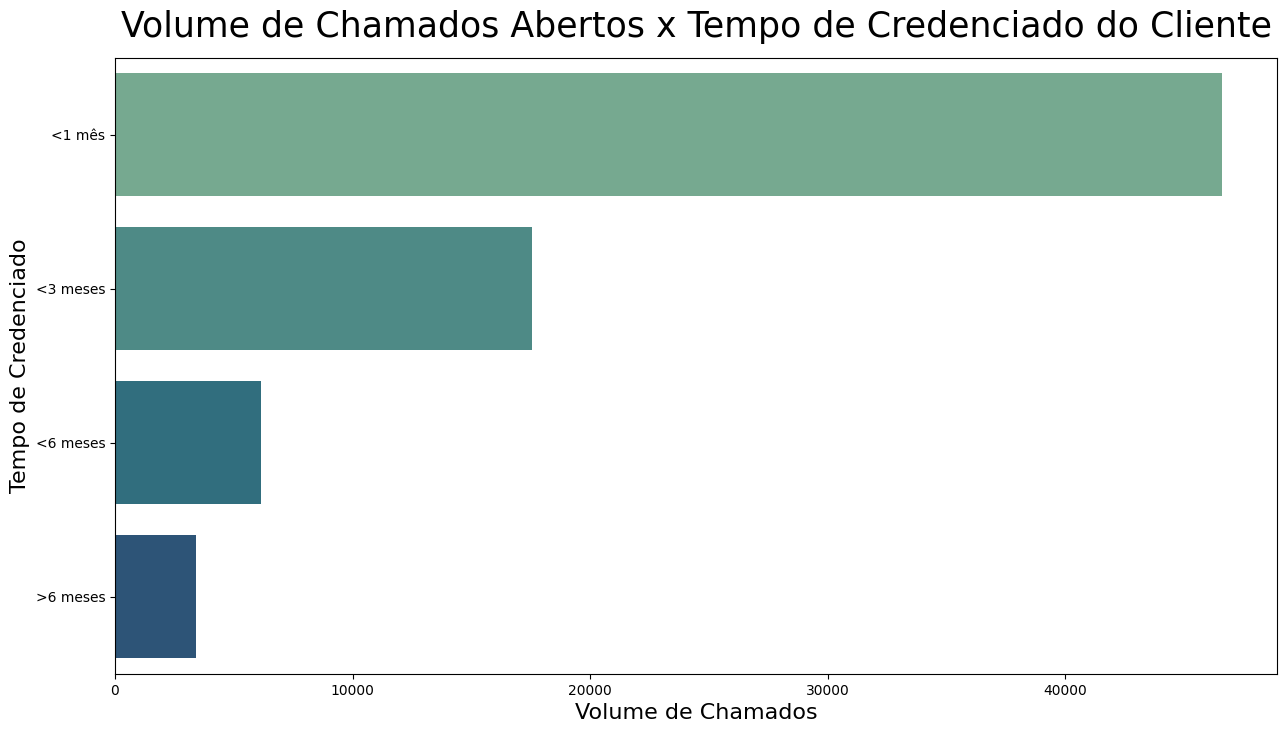

In [52]:
plt.figure(figsize=[15, 8])

chamados_idade = sns.barplot(x='Id', 
                             y='Classificacao', 
                             data=clientes_por_classificacao, 
                             palette='crest')

plt.title('Volume de Chamados Abertos x Tempo de Credenciado do Cliente', 
          size=25,
          pad=15)
plt.ylabel('Tempo de Credenciado', size=16)
plt.xlabel('Volume de Chamados', size=16)

plt.savefig('grafico_ChamadosPorIdade.png') #salvando o gráfico gerado em uma figura png
chamados_idade

#### 4.4 Análise dos assuntos dos chamados

In [53]:
assuntoPrincipal = cases.groupby('Assunto_Principal').count()['Id']
assuntoPrincipal = assuntoPrincipal.reset_index()
assuntoPrincipal.rename(columns={'Id': 'Frequência'}, inplace=True)
assuntoPrincipal.dropna(axis=0,
                        how='any',
                        inplace=True)
categoria_assunto = assuntoPrincipal.sort_values(by='Frequência', ascending=False).head(10)
categoria_assunto.set_index('Assunto_Principal', inplace=True)
dfi.export(categoria_assunto, 'categorias_assunto.png')

In [54]:
categoria_assunto.query('Frequência > 10000').sum()['Frequência'] / categoria_assunto['Frequência'].sum()

0.5580404001456633

In [55]:
subassunto1 = cases.groupby('SubAssunto_01').count()['Id']
subassunto1 = subassunto1.reset_index()
subassunto1.rename(columns={'Id': 'Frequência'}, inplace=True)
subassunto1.dropna(axis=0,
                   how='any',
                   inplace=True)
subassunto = subassunto1.sort_values(by='Frequência', ascending=False).head(10)
subassunto.set_index('SubAssunto_01', inplace=True)
dfi.export(subassunto, 'subassunto.png')

In [56]:
cases.head()

,Id,Data,Canal,Espera,Atendido,Pesquisa_Satisfacao,Assunto_Principal,SubAssunto_01,SubAssunto_02,Data_Credenciamento,Estado_Entrega,Produto_Adquirido,Dias_Credenciado
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Pedido,Cancelamento,Outros,2020-07-28,RJ,T3,3 days
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,Sim,NaN,Produto,Cartão pré-pago,Dúvidas,2020-07-28,RJ,T3,3 days
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Redefinição de senha,2020-07-28,RJ,T3,57 days
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Aplicativo,Dúvidas funcionalidades App,Prazos e taxas,2020-08-28,RJ,T1,1 days
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,Sim,NaN,Logística,OS,Confirmação/alteração de dados,2020-08-28,RJ,T1,1 days


#### 4.5 Correlacionando o assunto dos chamados com o produto adquirido

In [57]:
#criando um agrupamento das informações a partir do produto adquirido e do assunto do chamado
matriz = cases.groupby(['Produto_Adquirido', 'Assunto_Principal']).count()['Id']
#transformando a matriz em DataFrame
matriz = pd.DataFrame(matriz)
#ajustando a matriz para elaborar matriz de contingência
matriz = matriz.reset_index().pivot(index='Assunto_Principal', columns='Produto_Adquirido', values='Id').fillna(0)

In [58]:
matriz

Produto_Adquirido,NONE,T1,T2,T3
Assunto_Principal,,,,
,0.0,21.0,17.0,19.0
Aplicativo,103.0,3779.0,4631.0,4119.0
Bandeira,5.0,167.0,236.0,202.0
Bandeiras,2.0,56.0,48.0,35.0
Cadastro,36.0,1103.0,1470.0,1275.0
Comunicados,0.0,7.0,2.0,2.0
Feedback do cliente,3.0,224.0,298.0,213.0
Incidente,1.0,101.0,112.0,81.0
Logística,71.0,2754.0,3602.0,3084.0


In [59]:
statistic, prob, dof, ex = stats.chi2_contingency(matriz) #teste chi²
print(f'chi² = {statistic:.2f}\np = {prob:.2f}')

chi² = 51.75
p = 0.23


> Aceitamos a hipótese nula de que não haja correlação de dependência entre as variáveis da matriz.

In [60]:
matrizDistancia = gower.gower_matrix(matriz) #definindo a matriz de distanciamento

In [61]:
matrizCluster = DBSCAN(eps=0.5, 
                       min_samples=5, 
                       metric='euclidean') #definindo o modelo de clusterização

matrizCluster.fit(matrizDistancia) #ajustando o modelo à matriz de distância

matriz['cluster'] = matrizCluster.labels_ #incluindo o índice de clusterização na tabela

In [62]:
resultado = matriz.query('cluster == -1')

In [63]:
resultado.reset_index(inplace=True)
resultado.rename(columns={'Assunto_Principal': 'Assunto', 'NONE': 'Vazio', 'cluster': 'Cluster'}, inplace=True)
resultado.set_index('Assunto', inplace=True)
resultado['Cluster'] = resultado['Cluster'].map({-1: 1})

C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\3879616565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado.rename(columns={'Assunto_Principal': 'Assunto', 'NONE': 'Vazio', 'cluster': 'Cluster'}, inplace=True)
C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\3879616565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado['Cluster'] = resultado['Cluster'].map({-1: 1})


In [64]:
np.sum(np.array(matriz.query("cluster == 0")))

7872.0

In [65]:
matriz.query("cluster == 0").sum()

Produto_Adquirido
NONE         73.0
T1         2383.0
T2         2940.0
T3         2476.0
cluster       0.0
dtype: float64

In [66]:
np.sum(np.array(matriz.query("cluster == -1")))

39442.0

In [67]:
np.sum(np.array(matriz.query("cluster == -1"))) / len(cases)

0.5090012776006917

In [68]:
resultado1 = matriz.query('cluster == 0')
resultado1.reset_index(inplace=True)
resultado1.rename(columns={'Assunto_Principal': 'Assunto', 'NONE': 'Vazio', 'cluster': 'Cluster'}, inplace=True)
resultado1.set_index('Assunto', inplace=True)

C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\1034460821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado1.rename(columns={'Assunto_Principal': 'Assunto', 'NONE': 'Vazio', 'cluster': 'Cluster'}, inplace=True)


In [69]:
resultado1

Produto_Adquirido,Vazio,T1,T2,T3,Cluster
Assunto,,,,,
,0.0,21.0,17.0,19.0,0
Bandeira,5.0,167.0,236.0,202.0,0
Bandeiras,2.0,56.0,48.0,35.0,0
Comunicados,0.0,7.0,2.0,2.0,0
Feedback do cliente,3.0,224.0,298.0,213.0,0
Incidente,1.0,101.0,112.0,81.0,0
Outros,8.0,188.0,248.0,197.0,0
Pedido,22.0,592.0,753.0,628.0,0
Risco,1.0,37.0,32.0,37.0,0


In [70]:
dicionario = {}

matriz.reset_index(inplace=True)

for i, j in zip(list(matriz['Assunto_Principal']), list(matriz['cluster'])):
    dicionario[i] = j

dicionario

{'': 0,
 'Aplicativo': -1,
 'Bandeira': 0,
 'Bandeiras': 0,
 'Cadastro': -1,
 'Comunicados': 0,
 'Feedback do cliente': 0,
 'Incidente': 0,
 'Logística': -1,
 'Outros': 0,
 'Pedido': 0,
 'Produto': -1,
 'Risco': 0,
 'Telecom': 0,
 'Transação': 0,
 'Transferência de saldo': 0}

In [71]:
cases2 = cases.copy()
cases2['cluster'] = cases2['Assunto_Principal'].map(dicionario)

In [72]:
cases2.to_csv('base_chamados.csv')

### Gráficos gerados a partir das consultas realizadas no SQL

In [73]:
por_estado = pd.read_csv('UF.csv')
por_semana = pd.read_csv('ChamadosPorSemana_Clusterizado.csv')
serie_historica = pd.read_csv('SerieHistorica_Acumulado.csv')

<AxesSubplot: title={'center': 'Chamados Abertos por Estado'}, xlabel='UF', ylabel='Contagem de Chamados'>

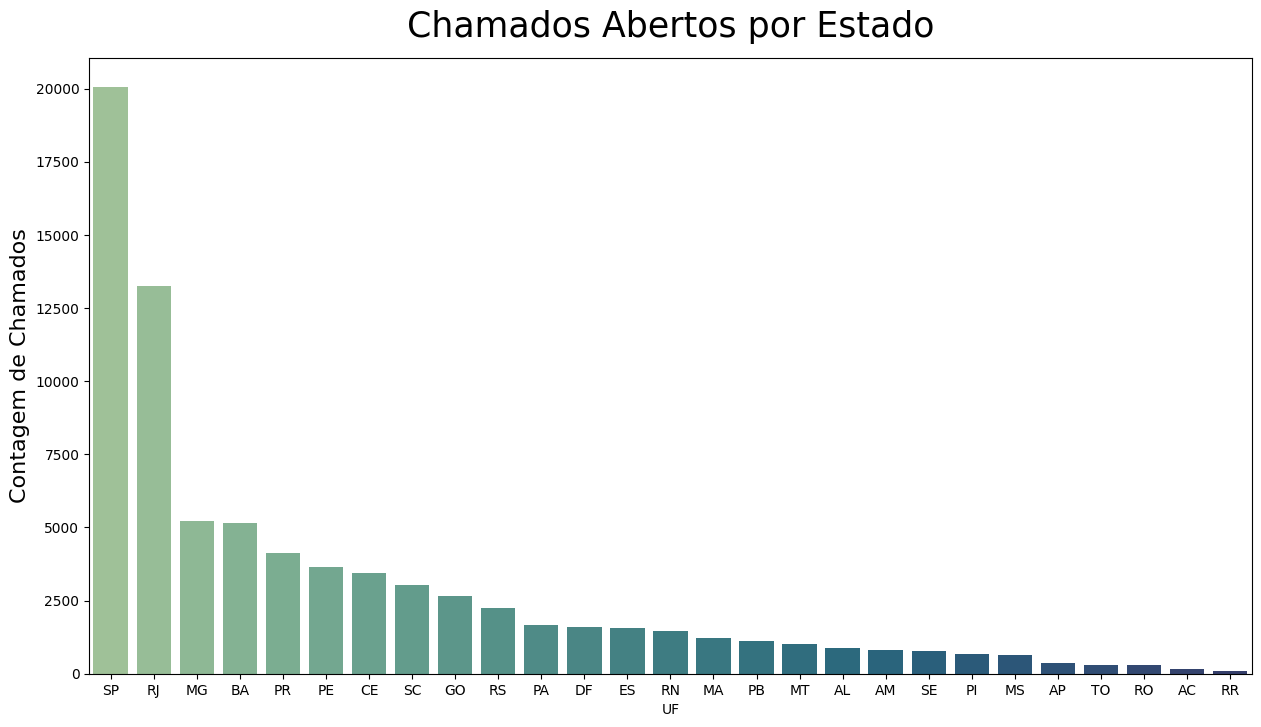

In [74]:
plt.figure(figsize=[15, 8])

grafico_uf = sns.barplot(x='UF', 
                         y='Chamados',
                         data=por_estado,
                         palette='crest')

plt.title('Chamados Abertos por Estado', 
          size=25,
          pad=15)

plt.ylabel('Contagem de Chamados', size=16)

plt.savefig('grafico_ChamadosUF.png') #salvando o gráfico gerado em uma figura png
grafico_uf

<AxesSubplot: title={'center': 'Frequência Diária Acumulada D-30 no Intervalo de Apuração'}, xlabel='Série Histórica', ylabel='Frequência Acumulada D-30'>

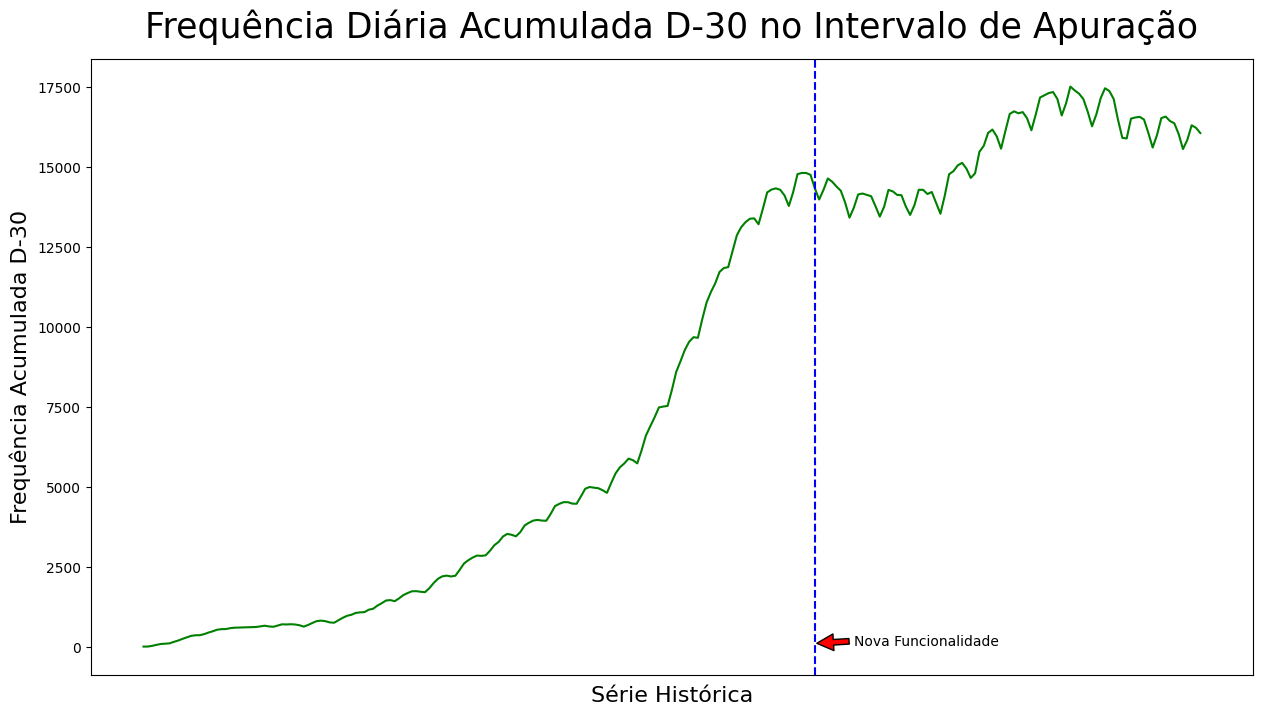

In [75]:
plt.figure(figsize=[15, 8])

acumulado30 = sns.lineplot(x='Data', 
                           y='Acumulado_30dias', 
                           data=serie_historica, 
                           color='g')

plt.title('Frequência Diária Acumulada D-30 no Intervalo de Apuração', 
          size=25, 
          pad=15)
plt.ylabel('Frequência Acumulada D-30', size=16)
plt.xlabel('Série Histórica', size=16)
plt.xticks([])

plt.axvline(x='2020-08-01', 
            ymin=0, 
            ymax=max(analise_chamados['Id']),
            color='b',
            linestyle='--')

plt.annotate('Nova Funcionalidade',
             xy=('2020-08-01', 100),
             xytext=('2020-08-10', 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.savefig('grafico_acumulado30.png') #salvando o gráfico gerado em uma figura png
acumulado30

In [76]:
por_semana = por_semana.fillna(0)

In [77]:
ps = por_semana.copy()

<AxesSubplot: >

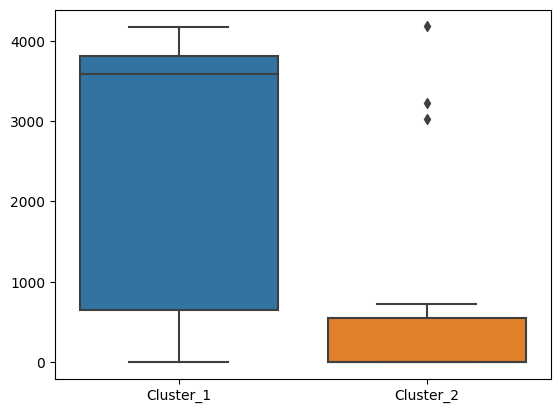

In [78]:
sns.boxplot(ps.set_index('Semana'))

<AxesSubplot: title={'center': 'Chamados Abertos por Semana por Cluster de Assuntos'}, xlabel='Cluster', ylabel='Chamados'>

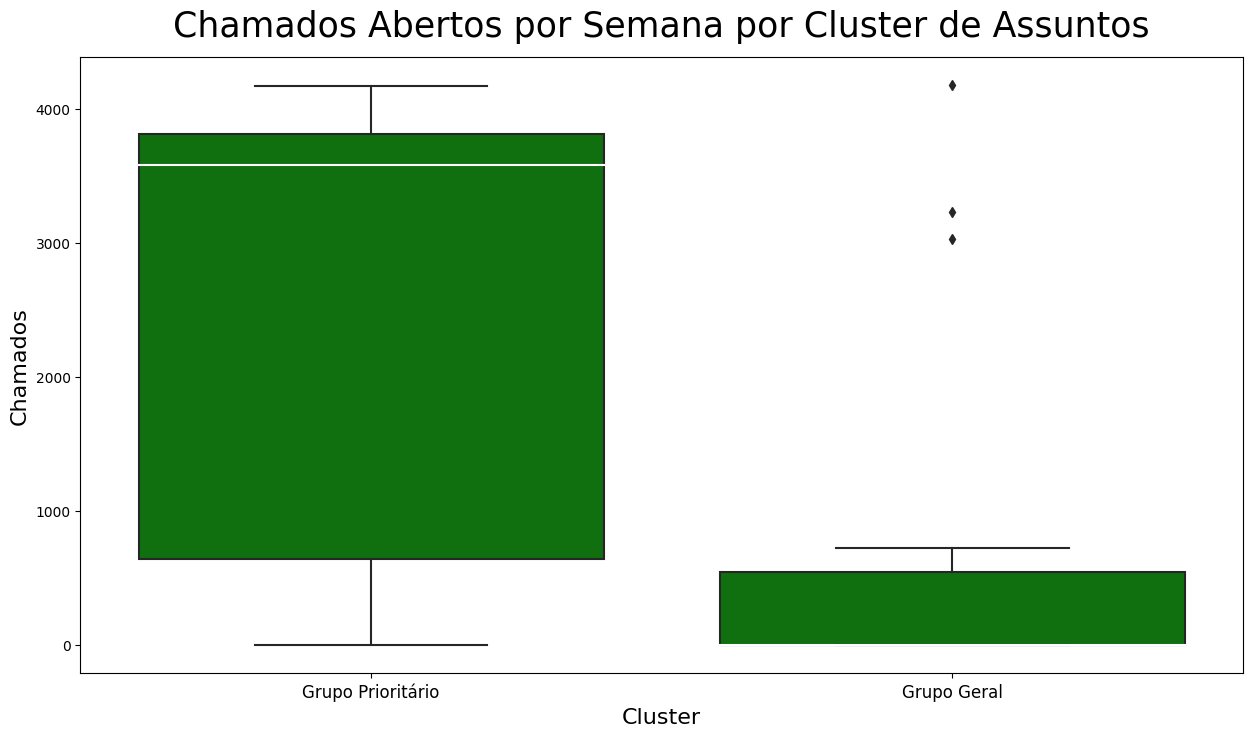

In [79]:
plt.figure(figsize=[15, 8])

chamados_semana = sns.boxplot(ps.set_index('Semana'),
                             color='green',
                             medianprops={'color': 'white'})

plt.title('Chamados Abertos por Semana por Cluster de Assuntos', 
          size=25,
          pad=15)
plt.ylabel('Chamados', size=16)
plt.xlabel('Cluster', size=16)

ticks, labels = plt.xticks()
plt.xticks(ticks, labels=['Grupo Prioritário', 'Grupo Geral'], size=12)

plt.savefig('Semana_por_Cluster.png') #salvando o gráfico gerado em uma figura png
chamados_semana

In [80]:
assunto = cases.groupby('Assunto_Principal').mean()['Espera']
uf = cases.groupby('Estado_Entrega').mean()['Espera']

C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\1507372579.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  assunto = cases.groupby('Assunto_Principal').mean()['Espera']
C:\Users\fvcar\AppData\Local\Temp\ipykernel_13276\1507372579.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  uf = cases.groupby('Estado_Entrega').mean()['Espera']


In [81]:
cases2['Espera'].mean()

17.224767386338705

In [85]:
cases2['Pesquisa_Satisfacao'] = cases2['Pesquisa_Satisfacao'].fillna('Não Respondido')

In [86]:
cases2.groupby('Pesquisa_Satisfacao').count()['Id']

Pesquisa_Satisfacao
Bom                 425
Cansativo             2
Enviado            9996
Feliz                19
Incrivel            899
MalAtendido          16
NaoResolveu         107
Normal              112
Não Respondido    65904
Pessimo               3
Triste                6
Name: Id, dtype: int64

In [87]:
analise = cases2.groupby('Pesquisa_Satisfacao').count()['Id']

In [88]:
x = pd.DataFrame(analise)

In [89]:
x.reset_index(inplace=True)

In [90]:
x = x.query("Pesquisa_Satisfacao != 'Enviado' and Pesquisa_Satisfacao != 'Não Respondido'")

In [91]:
x.set_index('Pesquisa_Satisfacao')

,Id
Pesquisa_Satisfacao,
Bom,425
Cansativo,2
Feliz,19
Incrivel,899
MalAtendido,16
NaoResolveu,107
Normal,112
Pessimo,3
Triste,6


In [93]:
lbl = list(x.reset_index()['Pesquisa_Satisfacao'])

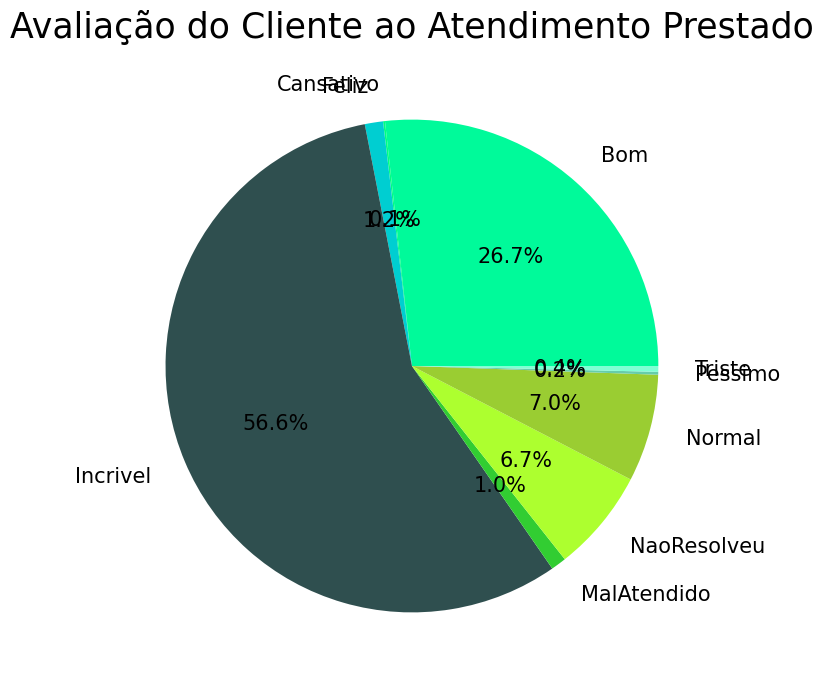

In [117]:
plt.figure(figsize=[15, 8])
cores= ['#00FA9A', '#00FF7F', '#00CED1', '#2F4F4F', '#32CD32', '#ADFF2F', '#9ACD32', '#66CDAA', '#7FFFD4']

_, texts, autotexts = plt.pie(x='Id', data=x, labels=lbl, labeldistance=1.15, colors=cores, autopct='%1.1f%%')
plt.title('Avaliação do Cliente ao Atendimento Prestado', size=25, pad=15)
plt.setp(autotexts, size=15)
plt.setp(texts, size=15)

plt.savefig('Avalia.png')